In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch import logsumexp
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 20
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 100
NUM_HIDDEN = 128
NUM_STATS = K+D*K
NUM_LATENTS = D * K
NUM_OBS = D + K
BATCH_SIZE = 100
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
CUDA = False

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Zs = torch.from_numpy(np.load('gmm_dataset/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset/means.npy')).float()
covs = torch.from_numpy(np.load('gmm_dataset/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Zs.shape[0]

In [4]:
def StatsGMM(Xs, Zs, K, D):
    """
    Xs is B * N * D
    Zs is B * N * K
    return B * (K+D*K)
    """
    stat1 = Zs.sum(1)
    stat2 = torch.mul(Zs.unsqueeze(-1).repeat(1, 1, 1, D), Xs.unsqueeze(-1).repeat(1, 1, 1, K).transpose(-1, -2)).sum(1) 
    return stat1, stat2, torch.cat((stat1, stat2.view(-1, D*K)), dim=-1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_stats))
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.ReLU())
        self.mean = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.log_std = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        hidden = self.enc_hidden(stats)
        mean = self.mean(hidden).view(-1, K, D)
        std = torch.exp(self.log_std(hidden).view(-1, K, D))
        mus = Normal(mean, std).sample((num_samples, )) ## S * B * K * D
        return mean, std, mus

In [6]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [9]:
def log_joints_gmm(Z, Pi, mus, covs, Xs, N, D, K, num_samples, batch_size):
    log_probs = torch.zeros((num_samples, batch_size)).float()
    ## S * B
    log_probs = log_probs + Normal(torch.zeros((batch_size, K, D)), torch.ones((batch_size, K, D))).log_prob(mus).sum(-1).sum(-1)
    ## Z B-by-T-by-K
    log_probs = log_probs + cat(Pi).log_prob(Z).sum(-1)
    labels = Z.nonzero()
    covs_expand = covs.unsqueeze(0).unsqueeze(0).repeat(num_samples, batch_size, 1, 1, 1)
    log_probs = log_probs + mvn(mus[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D), covs_expand[:, labels[:, 0], labels[:, -1], :].view(-1, batch_size, N, D, D)).log_prob(Xs).sum(-1)
    return log_probs

def conjugate_posterior(stat1, stat2, covs, K, D, batch_size):
    prior_covs_inv = torch.ones(K, D)
    covs_flat = torch.diagonal(covs, 0, -2, -1).unsqueeze(0).repeat(BATCH_SIZE, 1, 1) #B * K * D
    posterior_covs = 1. / (prior_covs_inv + torch.mul(stat1.unsqueeze(-1).repeat(1, 1, D), 1. / covs_flat))
    posterior_mean = torch.mul(posterior_covs, torch.mul(stat2, 1. / covs_flat))
    return posterior_mean, posterior_covs

def kl_normal_normal(p_mean, p_std, q_mean, q_std):
    var_ratio = (p_std / q_std).pow(2)
    t1 = ((p_mean - q_mean) / q_std).pow(2)
    return 0.5 * (var_ratio + t1 - 1 - var_ratio.log())

def kls_gaussians(mus, mus_mean, mus_std, posterior_mean, posterior_covs, K, D):
    log_q = Normal(mus_mean, mus_std).log_prob(mus).sum(-1).sum(-1)
    log_p = Normal(posterior_mean, torch.sqrt(posterior_covs)).log_prob(mus).sum(-1).sum(-1)
    MCKl = (log_q - log_p).mean(0).mean()
    TrueKl = kl_normal_normal(mus_mean, mus_std, posterior_mean, torch.sqrt(posterior_covs)).mean()
    return MCKl, TrueKl
    
def rws(Xs, Zs, Pi, covs, N, K, D, num_samples, batch_size):
    stat1, stat2, stats = StatsGMM(Xs, Zs, K, D)
    data = torch.cat((Xs, Zs), dim=-1).view(batch_size*N, -1)
    mus_mean, mus_std, mus = enc(data, K, D, num_samples, batch_size)
    log_q = Normal(mus_mean, mus_std).log_prob(mus).sum(-1).sum(-1) ## S * B
    log_p = log_joints_gmm(Zs, Pi, mus, covs, Xs, N, D, K, num_samples, batch_size)
    log_weights = log_p - log_q
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
    posterior_mean, posterior_covs = conjugate_posterior(stat1, stat2, covs, K, D, batch_size)
    MCKl, TrueKl = kls_gaussians(mus, mus_mean, mus_std, posterior_mean, posterior_covs, K, D)
    return eubo, elbo, ess, MCKl, TrueKl

In [10]:
EUBOs = []
ELBOs = []
ESSs = []
MCKls = []
TrueKls = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    time_start = time.time()
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    MCKl = 0.0
    TrueKl = 0.0
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Zs = Zs[batch_indices]
        eubo, elbo, ess, mckl, truekl = rws(batch_Xs, batch_Zs, Pi, covs, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        MCKl += mckl.item()
        TrueKl += truekl.item()
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    MCKl /= num_batches
    TrueKl /= num_batches
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    MCKls.append(MCKl)
    TrueKls.append(TrueKl)
    
    time_end = time.time()
    print('epoch=%d, EUBO=%f, ELBO=%f, ESS=%.3f, MCKL=%f, TKL=%f (%ds)' % (epoch, EUBO, ELBO, ESS, MCKl, TrueKl, time_end - time_start))

epoch=0, EUBO=-177.403854, ELBO=-370.303625, ESS=1.123, MCKL=256.114752, TKL=42.486810 (10s)
epoch=1, EUBO=-133.156198, ELBO=-442.028790, ESS=1.195, MCKL=327.839951, TKL=54.432954 (10s)
epoch=2, EUBO=-114.576050, ELBO=-184.284698, ESS=1.924, MCKL=70.095840, TKL=11.679213 (10s)
epoch=3, EUBO=-113.238106, ELBO=-129.235562, ESS=4.444, MCKL=15.046702, TKL=2.509401 (10s)
epoch=4, EUBO=-112.438470, ELBO=-123.694724, ESS=6.407, MCKL=9.505855, TKL=1.586047 (10s)
epoch=5, EUBO=-112.259877, ELBO=-120.612958, ESS=8.662, MCKL=6.424096, TKL=1.071118 (10s)
epoch=6, EUBO=-112.295560, ELBO=-119.722981, ESS=9.128, MCKL=5.534119, TKL=0.922273 (10s)
epoch=7, EUBO=-112.580875, ELBO=-118.039452, ESS=12.821, MCKL=3.850584, TKL=0.635341 (10s)
epoch=8, EUBO=-112.666298, ELBO=-117.658817, ESS=14.093, MCKL=3.469942, TKL=0.578683 (10s)
epoch=9, EUBO=-112.715749, ELBO=-117.200119, ESS=15.416, MCKL=3.011256, TKL=0.503529 (10s)
epoch=10, EUBO=-112.727887, ELBO=-117.118146, ESS=15.543, MCKL=2.929283, TKL=0.489533 (1

KeyboardInterrupt: 

In [16]:
def plot_results(EUBOs, ELBOs, ESS, MCKls, TrueKls, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(20, 20))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax2.plot(TrueKls, 'k', label='true KL')
    ax2.plot(MCKls, 'orange', label='est KL')
    ax1.tick_params(labelsize=14)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, lr=%d, samples=%d' % (num_epochs, lr, num_samples), fontsize=14)
    ax1.set_ylim([-180, -80])
    ax1.legend()
    ax2.set_ylim([-0.5, 50])
    ax2.legend()
    plt.savefig('gmm_rws_datatodist_lr=%f_samples=%d.svg' % (lr, num_samples))

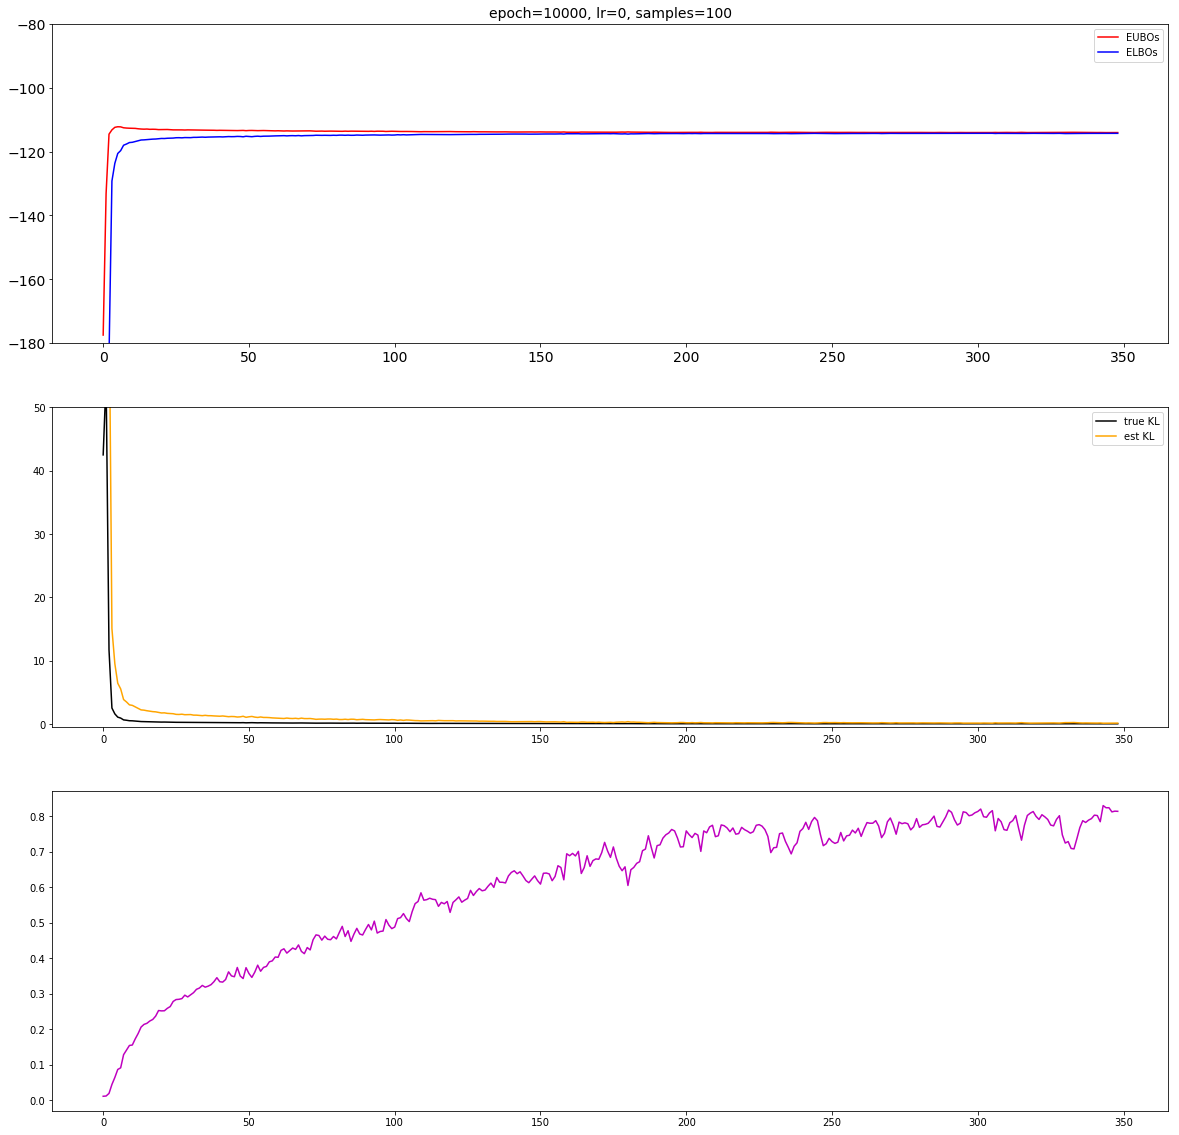

In [17]:
plot_results(EUBOs, ELBOs, ESS, MCKls, TrueKls, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)